In [1]:
import string
import re
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import gensim 
import fasttext

from sklearn.decomposition import PCA
from gensim.models import FastText as FT_gensim
from gensim.test.utils import datapath
from gensim.models.wrappers import FastText as FT

%matplotlib inline
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egapa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_excel("../dataset_twitter.xlsx")
df

,label,komentar
0,positif,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
1,positif,"Sharing pengalaman aja, kemarin jam 18.00 bata..."
2,positif,Sharing sama temen tuh emg guna bgt. Disaat lu...
3,positif,"sangat bersyukur bisa mendoakan kakeknya, Bung..."
4,positif,H-9. Mau ke bank rame bgt ampe antrian tempat ...
...,...,...
3110,netral,bukan saya yang tidak-mau merit sat ini hubung...
3111,netral,Baru lihat kabar Teman nge gosip dan penuh inf...
3112,netral,Mengubah kebiasaan seseorang yg kurang baik it...
3113,netral,nah diam lebih bagus yaudah saya diam saja deh...


In [3]:
df['label'].value_counts()

negatif    1101
positif    1017
netral      997
Name: label, dtype: int64

In [4]:
komentar = df['komentar'].astype(str)

#Lower case
komentar = komentar.apply(lambda x: x.lower())

#Remove URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

#Remove Number
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

#Before Punctuation
komentar = komentar.apply(lambda x: re.sub(r'(?<=[,.])(?=[^\s])', r' ', x))

#Punctuation
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Remove Non Alphanumeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

#Tokenizing
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

komentar

0       [kepingin, gudeg, mbarek, bu, hj, amad, foto, ...
1       [sharing, pengalaman, aja, kemarin, jam, batal...
2       [sharing, sama, temen, tuh, emg, guna, bgt, di...
3       [sangat, bersyukur, bisa, mendoakan, kakeknya,...
4       [h, mau, ke, bank, rame, bgt, ampe, antrian, t...
                              ...                        
3110    [bukan, saya, yang, tidakmau, merit, sat, ini,...
3111    [baru, lihat, kabar, teman, nge, gosip, dan, p...
3112    [mengubah, kebiasaan, seseorang, yg, kurang, b...
3113    [nah, diam, lebih, bagus, yaudah, saya, diam, ...
3114    [ya, allah, hanya, engkau, yang, mengetahui, r...
Name: komentar, Length: 3115, dtype: object

In [5]:
model_gensim = FT_gensim(size=300, 
                         negative=5, 
                         min_count=1, 
                         min_n=2, 
                         max_n=3, 
                         sg=0, 
                         sorted_vocab=1, 
                         word_ngrams=1, 
                         window=5, 
                         callbacks=(),
                         ns_exponent=0.75, 
                         cbow_mean=0, 
                         workers=5, 
                         alpha=0.1, 
                         min_alpha=0.025)

In [6]:
model_gensim.build_vocab(komentar)

In [7]:
total_examples = model_gensim.corpus_count
model_gensim.train(
    sentences=komentar,
    total_examples=total_examples, 
    epochs = 100
)

In [8]:
model_gensim.save('XGB.bin')
loaded_model = FT_gensim.load('XGB.bin')

In [9]:
loaded_model.wv.similarity("bagus", "buruk")

0.19848755

In [10]:
loaded_model.wv.distance("bagus", "jelek")

0.7029083371162415

In [11]:
loaded_model.wv.most_similar(positive="jelek", topn=5)

[('jek', 0.8707308769226074),
 ('jelekin', 0.8257787227630615),
 ('jele', 0.815099835395813),
 ('jeleknya', 0.8143316507339478),
 ('melek', 0.7795506715774536)]

In [12]:
loaded_model.wv.most_similar_cosmul(positive="bagus", negative=None, topn=5)

[('agus', 0.9205594062805176),
 ('sebagus', 0.9130353927612305),
 ('bagusnya', 0.9100965857505798),
 ('bagusan', 0.9065378308296204),
 ('baguslah', 0.898527979850769)]

In [13]:
similar_words = {search_term: [item[0] for item in loaded_model.wv.most_similar([search_term], topn=5)]
                for search_term in ['mantap', 'keren', 'bagus', 'jelek', 'parah', 'cepat']}
similar_words

{'mantap': ['mantapp', 'mantapkan', 'mantan', 'mantanmantan', 'mangap'],
 'keren': ['kemren', 'kmren', 'ken', 'kereboot', 'paytren'],
 'bagus': ['agus', 'sebagus', 'bagusnya', 'bagusan', 'baguslah'],
 'jelek': ['jek', 'jelekin', 'jele', 'jeleknya', 'melek'],
 'parah': ['arah', 'terparah', 'searah', 'marah', 'parahnya'],
 'cepat': ['cepatcepat', 'secepat', 'tepat', 'sepat', 'dipercepat']}

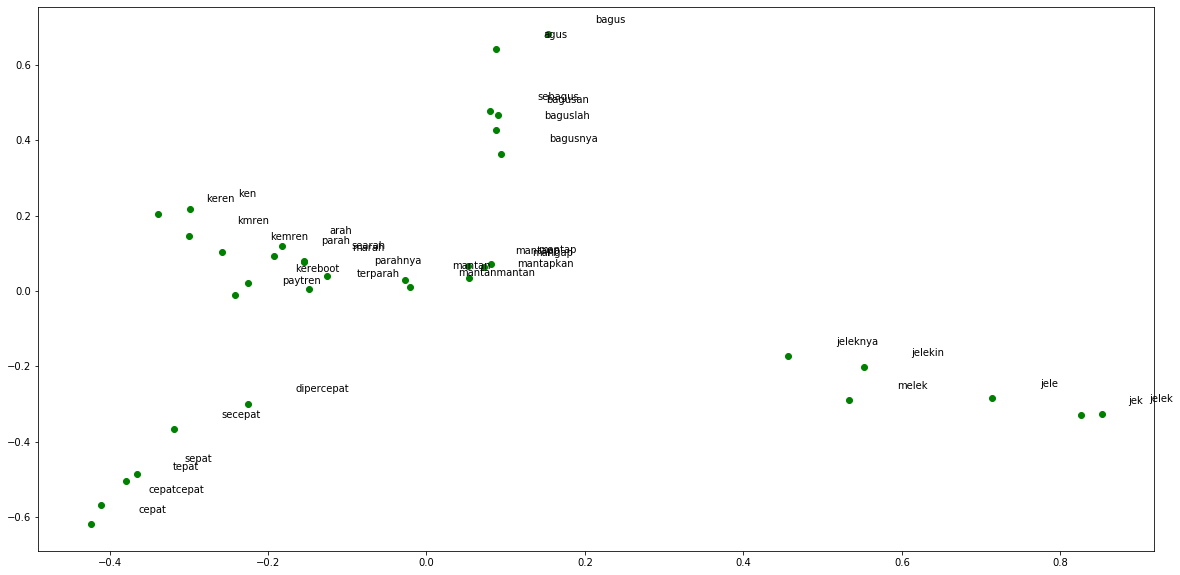

In [14]:
words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = loaded_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(20, 10))
plt.scatter(P[:, 0], P[:, 1], c='green', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')